# Network interpretability of lung X-rays

In this tutorial, we demonstrate visualising network interpretability through a classification task.

The data are a set of X-rays collated from a variety of sources. The labels used are:
- normal (the absence of the following classes)
- pneumonia
- covid

We then use GradCam and occlusion sensitivity to interpret the trained network's classification choices.

We explore some of MONAI's interpretability classes:
- `OcclusionSensitivity`,
- `GradCAM++`,

For brevity, we don't bother with splitting into training and validation datasets.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/modules/interpretability/covid_classification.ipynb)

In [1]:
from glob import glob
import os
from enum import Enum
import torch
import monai.transforms as mt
import random
from monai.networks.utils import eval_mode
from contextlib import nullcontext
from matplotlib import pyplot as plt
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import DenseNet121
import numpy as np
from tqdm.notebook import tqdm, trange
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from monai.visualize import GradCAMpp, OcclusionSensitivity
from monai.utils import set_determinism
from monai.apps import download_and_extract
import tempfile

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_determinism(0)

# Download the data

The data is currently hosted on [Kaggle](https://www.kaggle.com/ericspod/project-monai-2020-bootcamp-challenge-dataset) and [Zenodo](https://zenodo.org/record/4621066). Here, we'll download the data from Zenodo. For ease, we'll only use the images in the training folder

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else os.path.expanduser(directory)
print(root_dir)

/nfs/home/rbrown/Documents/Data/MONAI


In [3]:
train_url = "https://zenodo.org/record/4621066/files/training_data.zip?download=1"
train_md5 = "3e8d3e6ca43903ead0666eb6ec8849d8"
train_zip = os.path.join(root_dir, "covid_train.zip")
train_dir = os.path.join(root_dir, "covid")
download_and_extract(train_url, train_zip, train_dir, train_md5)

2022-09-30 15:21:40,932 - INFO - Verified 'covid_train.zip', md5: 3e8d3e6ca43903ead0666eb6ec8849d8.
2022-09-30 15:21:40,933 - INFO - File exists: /nfs/home/rbrown/Documents/Data/MONAI/covid_train.zip, skipped downloading.
2022-09-30 15:21:40,934 - INFO - Writing into directory: /nfs/home/rbrown/Documents/Data/MONAI/covid.


In [4]:
class Diagnosis(Enum):
    normal = 0
    pneumonia = 1
    covid = 2


num_class = len(Diagnosis)


def get_label(path):
    fname = os.path.basename(path)
    if fname[:6] == "normal":
        return Diagnosis.normal.value
    elif fname[:9] == "pneumonia":
        return Diagnosis.pneumonia.value
    elif fname[:5] == "covid":
        return Diagnosis.covid.value
    else:
        raise RuntimeError(f"Unknown label: {path}")


def get_data(balance_classes=True):
    data = {}
    for d in Diagnosis:
        files = glob(os.path.join(train_dir, f"{d.name}*.png"))
        random.shuffle(files)
        data[d] = files
    num_ims = {k: len(v) for k, v in data.items()}
    print("Num classes -- " + ", ".join(f"{k.name}: {v}" for k, v in num_ims.items()))
    if balance_classes:
        # fewest images of any diagnosis
        num_to_keep = min(num_ims.values())
        data = {k: v[:num_to_keep] for k, v in data.items()}
        print("After balance -- " + ", ".join(f"{k.name}: {len(v)}" for k, v in data.items()))
    all_data = []
    for diagnosis, files in data.items():
        for f in files:
            all_data.append({"image": f, "label": diagnosis.value})
    random.shuffle(all_data)
    return all_data


all_data = get_data()

Num classes -- normal: 150, pneumonia: 150, covid: 949
After balance -- normal: 150, pneumonia: 150, covid: 150


In [5]:
batch_size = 10
divisible_factor = 16
crop_size = (320, 320)  # set size of images for network

transforms = mt.Compose([
    mt.LoadImaged("image", image_only=True),
    mt.EnsureChannelFirstd("image"),
    mt.Rotate90d("image", k=3),
    mt.DivisiblePadd("image", k=divisible_factor),
    # some images have extra channels, just take first
    mt.Lambdad("image", lambda im: im[:1] if im.shape[0] > 1 else im),
    mt.Resized("image", spatial_size=crop_size, mode="area"),
    mt.ToTensord("image", track_meta=False),
])

ds = CacheDataset(all_data, transforms)
dl = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=10,
    drop_last=True,
)

Loading dataset: 100%|██████████| 450/450 [00:10<00:00, 42.85it/s]


In [6]:
def imshow(data):
    nims = len(data)
    if nims < 6:
        shape = (1, nims)
    else:
        shape = int(np.floor(np.sqrt(nims))), int(np.ceil(np.sqrt(nims)))
    fig, axes = plt.subplots(*shape, figsize=(20, 20), facecolor="white")
    axes = np.asarray(axes) if nims == 1 else axes
    for d, ax in zip(data, axes.ravel()):
        # channel last for matplotlib
        im = d["image"][0].cpu().numpy()
        ax.imshow(im, cmap='gray')
        ax.set_title(Diagnosis(d["label"]).name, fontsize=25)
        ax.axis("off")
    plt.show()

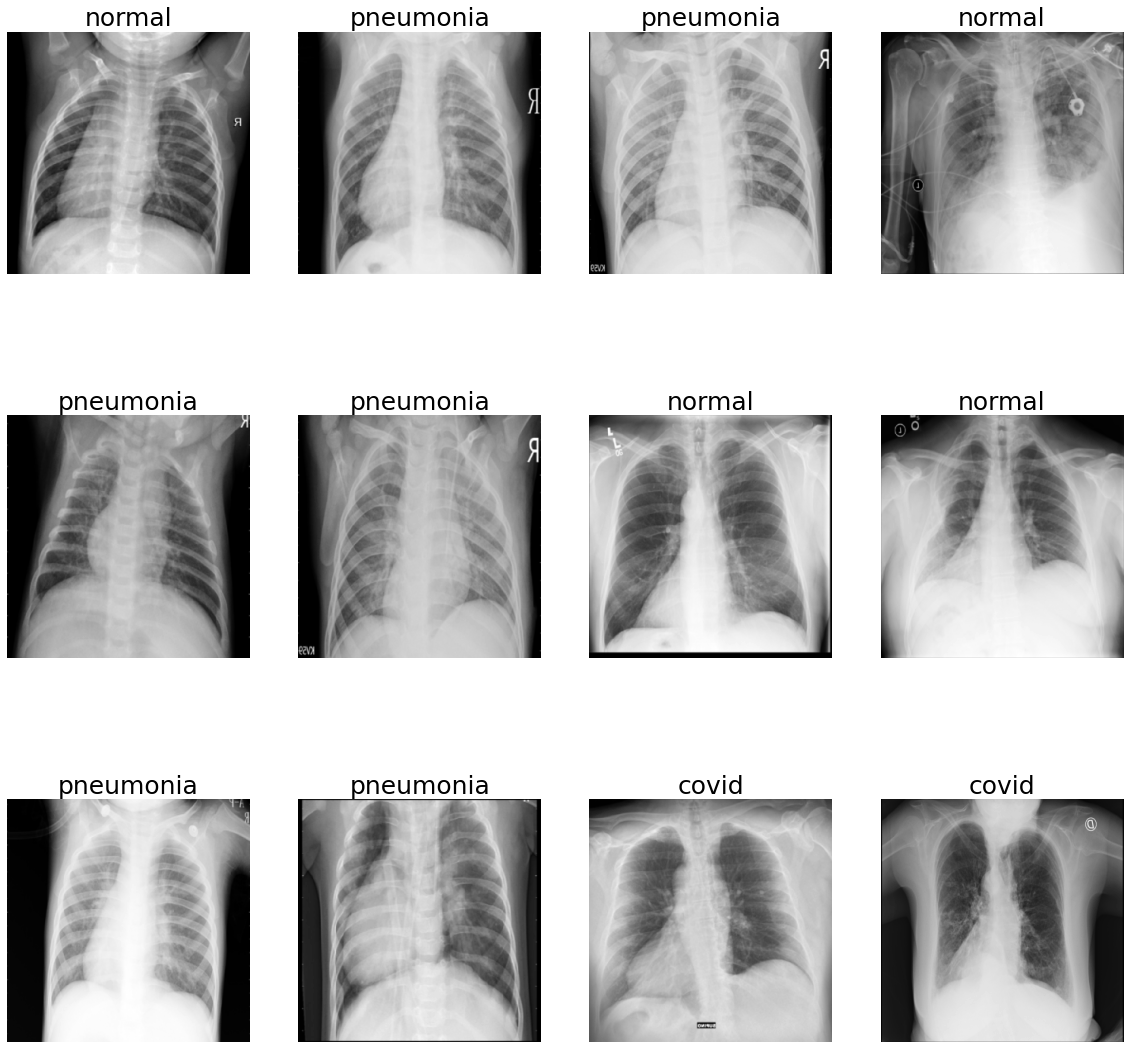

In [7]:
# Random images
rand_idxs = np.random.choice(len(ds), size=12, replace=False)
imshow([ds[i] for i in rand_idxs])

In [8]:
model = DenseNet121(
    spatial_dims=2, in_channels=1, out_channels=len(Diagnosis), pretrained=False,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
use_amp = True
label_dtype = torch.float16 if use_amp else torch.float32
scaler = torch.cuda.amp.GradScaler() if use_amp else None


def criterion(y_pred, y):
    return torch.nn.functional.cross_entropy(y_pred, y, reduction="sum")


def get_num_correct(y_pred, y):
    return (y_pred.argmax(dim=1) == y).sum().item()

In [9]:
max_epochs = 20
tr = trange(max_epochs, desc="Epoch")
for epoch in tr:
    loss, acc = 0, 0
    for data in tqdm(dl, desc="Train DL", leave=False):
        inputs, labels = data["image"].to(device), data["label"].to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast() if use_amp else nullcontext():
            outputs = model(inputs)
            train_loss = criterion(outputs, labels)
            acc += get_num_correct(outputs, labels)
        if use_amp:
            scaler.scale(train_loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        loss += train_loss.item()
    loss /= (len(dl) * batch_size)
    acc /= (len(dl) * batch_size)
    tr.set_description(f"Epoch {epoch+1}, loss: {loss:.3f}, acc: {acc:.4f}")

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

Train DL:   0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

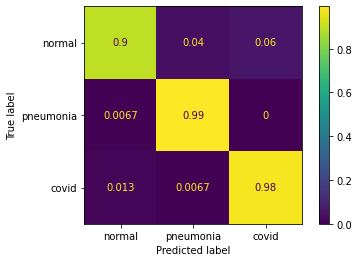

In [10]:
model.eval()
with eval_mode(model):
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for data in tqdm(dl):
        images, labels = data["image"].to(device), data["label"].to(device)
        with torch.cuda.amp.autocast() if use_amp else nullcontext():
            outputs = model(images).detach()
        y_pred = torch.cat([y_pred, outputs], dim=0)
        y = torch.cat([y, labels], dim=0)

    y_pred = y_pred.argmax(dim=1)

    cm = confusion_matrix(
        y.cpu().numpy(),
        y_pred.cpu().numpy(),
        normalize='true',
    )
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[d.name for d in Diagnosis],
    )
    _ = disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

# Interpretability

Now we compare our different saliency methods. Initially, the resulting can be tricky to decipher.

## Occlusion sensitivity
With occlusion sensitivity we iteratively block off part of the image and then we record the changes in certainty of the inferred class. This means that for instances where the network correctly infers the image type, we expect the certainty to drop as we occlude important parts of the image. Hence, for correct inference, blue parts of the image imply importance.

This is also true when the network **incorrectly** infers the image; blue areas were important in inferring the given class.

## GradCAM
The user chooses a layer of the network that interests them and the gradient is calculated at this point. The chosen layer is typically towards the bottom of the network, as all the features have hopefully been extracted by this point. The images have been downsampled many times, and so the resulting images are linearly upsampled to match the size of the input image. As with occlusion sensitivity, blue parts of the image imply importance in the decision making process.

In [17]:
# for name, _ in model.named_modules(): print(name)
target_layer = "class_layers.relu"
gradcampp = GradCAMpp(model, target_layers=target_layer)
occ_sens = OcclusionSensitivity(
    model, mask_size=32, n_batch=batch_size, overlap=0.75, verbose=False,
)

In [18]:
def saliency(model, d):
    ims = []
    titles = []
    log_scales = []

    img = torch.as_tensor(d["image"])[None].to(device)
    pred_logits = model(img)
    pred_label = pred_logits.argmax(dim=1).item()
    pred_prob = int(torch.nn.functional.softmax(pred_logits, dim=1)[0, pred_label].item() * 100)
    # Image
    ims.append(img[0])
    title = f"GT: {Diagnosis(d['label']).name}, "
    title += f"pred: {Diagnosis(pred_label).name} ({pred_prob}%)"
    titles.append(title)
    log_scales.append(False)

    # Occlusion sensitivity images
    occ_map, _ = occ_sens(img)
    ims.append(occ_map[0, pred_label][None])
    titles.append("Occ. sens.")
    log_scales.append(False)

    # GradCAM
    res_cam_pp = gradcampp(x=img, class_idx=pred_label)[0]
    ims.append(res_cam_pp)
    titles.append("GradCAMpp")
    log_scales.append(False)

    return ims, titles, log_scales

In [19]:
def add_im(im, title, log_scale, row, col, num_examples, cmap):
    ax = axes[row, col] if num_examples > 1 else axes[col]
    im = im[0]
    if isinstance(im, torch.Tensor):
        im = im.detach().cpu()
    im_show = ax.imshow(im, cmap=cmap)
    ax.set_title(title, fontsize=25)
    ax.axis("off")
    if col > 0:
        fig.colorbar(im_show, ax=ax)


def add_row(ims, titles, log_scales, row, axes, num_examples):
    for col, (im, title, log_scale) in enumerate(zip(ims, titles, log_scales)):
        cmap = "gray" if col == 0 else "jet"
        if log_scale and im.min() < 0:
            im -= im.min()
        add_im(im, title, log_scale, row, col, num_examples, cmap)

  0%|          | 0/5 [00:00<?, ?it/s]

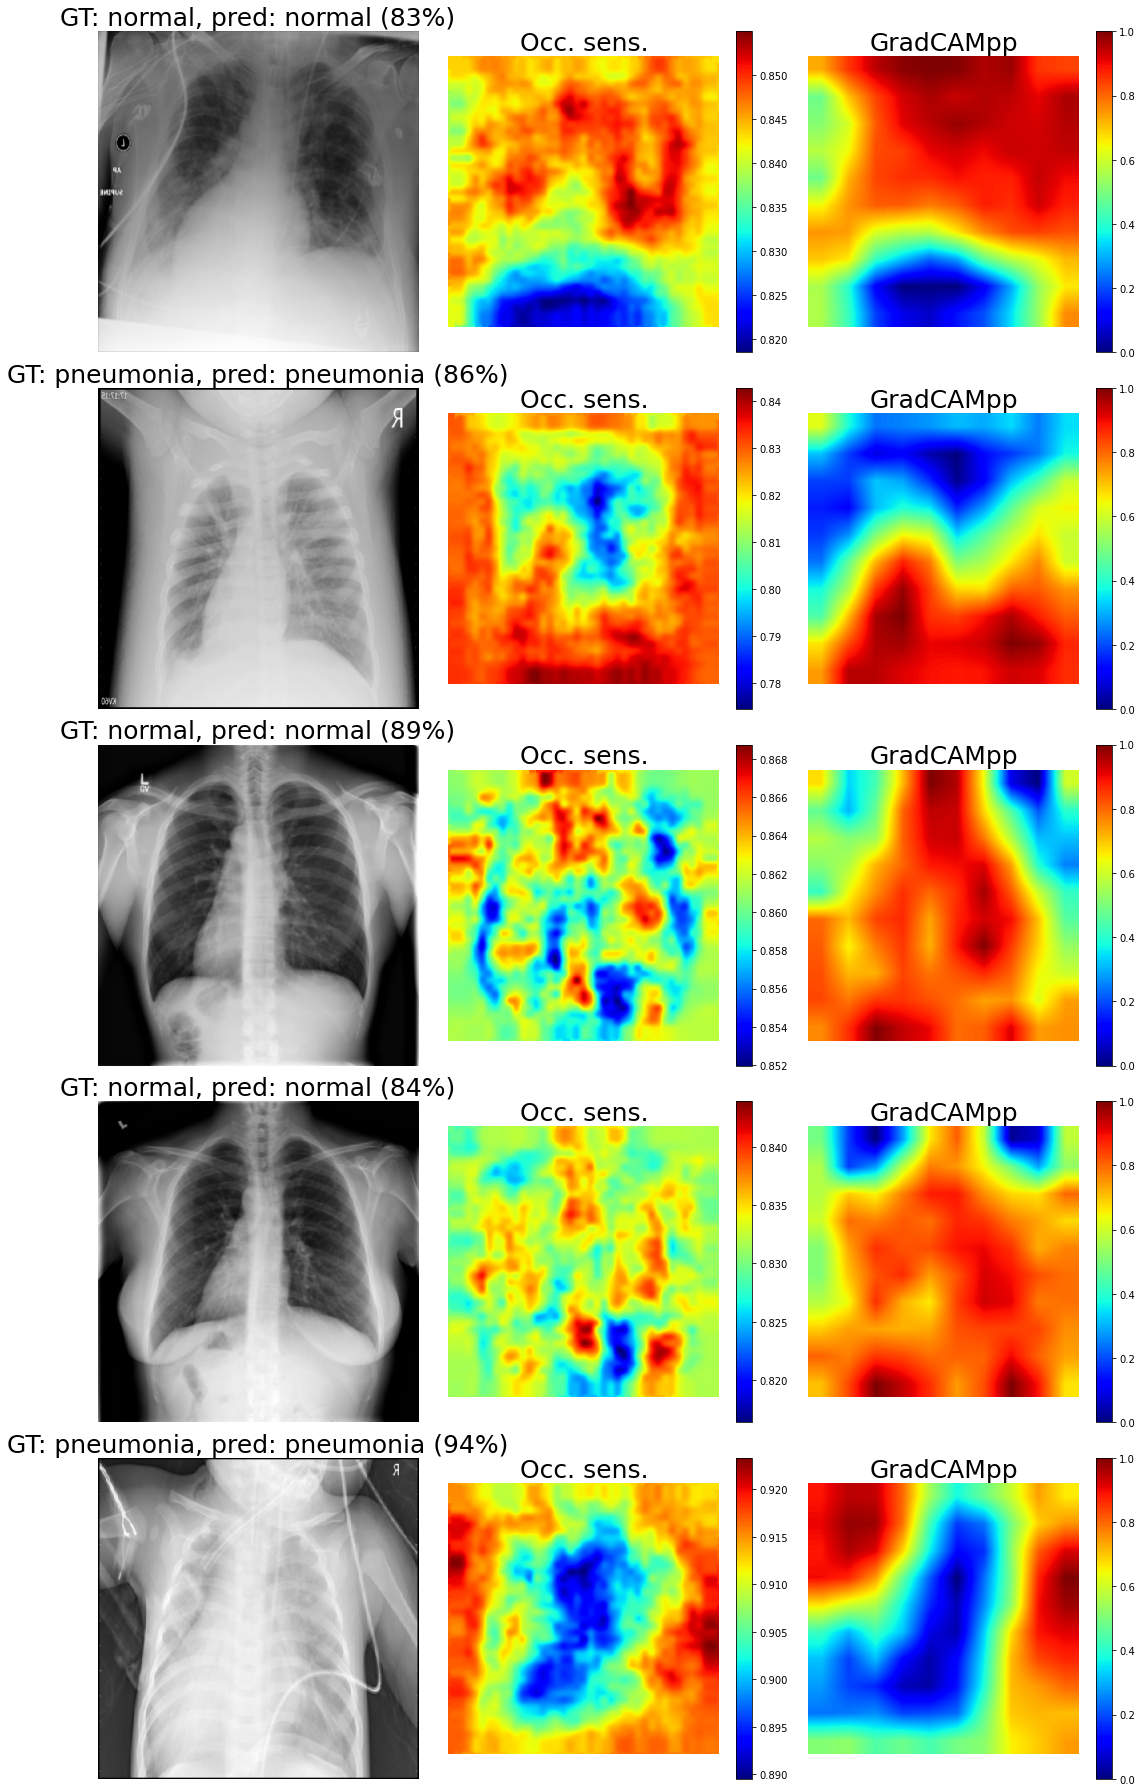

In [20]:
num_examples = 5
rand_data = np.random.choice(ds, replace=False, size=num_examples)
for row, d in enumerate(tqdm(rand_data)):
    ims, titles, log_scales = saliency(model, d)
    if row == 0:
        num_cols = len(ims)
        subplot_shape = [num_examples, num_cols]
        figsize = [i * 5 for i in subplot_shape][::-1]
        fig, axes = plt.subplots(*subplot_shape, figsize=figsize, facecolor='white')
    add_row(ims, titles, log_scales, row, axes, num_examples)
plt.tight_layout()